In [ ]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns


In [ ]:
# Set display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [ ]:
# 2. Load data
# Loading the correct file: 'smev_data.xlsx - EV Industries.csv'
try:
    data_smev = pd.read_excel("/content/smev_data.xlsx", sheet_name=None)
    df_industries = data_smev['EV Industries']
    print(df_industries)
    print("Successfully loaded 'smev_data.xlsx -> EV Industries.csv'")
except FileNotFoundError:
    print("Error: 'smev_data.xlsx -> EV Industries.csv' not found. Please ensure the file is uploaded.")
    exit()

        category financial_year  num_vehicles
0   E-2 Wheelers        2017-18          1981
1   E-2 Wheelers        2018-19         27478
2   E-2 Wheelers        2019-20         26512
3   E-2 Wheelers        2020-21         44294
4   E-2 Wheelers        2021-22        249615
5   E-2 Wheelers        2022-23        728090
6   E-3 Wheelers        2017-18         91970
7   E-3 Wheelers        2018-19        116031
8   E-3 Wheelers        2019-20        143051
9   E-3 Wheelers        2020-21         90898
10  E-3 Wheelers        2021-22        172543
11  E-3 Wheelers        2022-23        401882
12  E-4 Wheelers        2017-18          2242
13  E-4 Wheelers        2018-19          2407
14  E-4 Wheelers        2019-20          2404
15  E-4 Wheelers        2020-21          5201
16  E-4 Wheelers        2021-22         19782
17  E-4 Wheelers        2022-23         48105
18       E-Buses        2017-18            35
19       E-Buses        2018-19            75
20       E-Buses        2019-20   

In [ ]:
# avoid SettingWithCopyWarning when modifying slices or views of DataFrames
df_market = df_industries.copy()

In [ ]:
# 3. Explore the data
print("\n--- Data Exploration ---")
print("Columns:", df_market.columns.tolist())
print("Shape:", df_market.shape)
print("\nFirst 5 rows:")
print(df_market.head())
print("\nData types:")
print(df_market.dtypes)
print("\nMissing values:")
print(df_market.isnull().sum())


--- Data Exploration ---
Columns: ['category', 'financial_year', 'num_vehicles']
Shape: (24, 3)

First 5 rows:
       category financial_year  num_vehicles
0  E-2 Wheelers        2017-18          1981
1  E-2 Wheelers        2018-19         27478
2  E-2 Wheelers        2019-20         26512
3  E-2 Wheelers        2020-21         44294
4  E-2 Wheelers        2021-22        249615

Data types:
category          object
financial_year    object
num_vehicles       int64
dtype: object

Missing values:
category          0
financial_year    0
num_vehicles      0
dtype: int64


In [ ]:
# Identify relevant columns - using the correct names from 'EV Industries.csv'
category_col = 'category'
year_col = 'financial_year'
sales_col = 'num_vehicles'

# Basic check if essential columns exist
if category_col not in df_market.columns or year_col not in df_market.columns or sales_col not in df_market.columns:
     print(f"Data Error: Essential columns ('{category_col}', '{year_col}', '{sales_col}') not found.")
     exit()
else :
  print('ok :)')


ok :)


In [ ]:
# Sales col val to num + drop NaN/missing val

df_market[sales_col] = pd.to_numeric(df_market[sales_col], errors='coerce') #sales column vals to numeric vals
# coerce :- string or non-convertible -> NaN
df_market.dropna(subset=[sales_col], inplace=True) # Drop rows where sales could not be converted(NaN)

In [ ]:
print(f"\nUnique Categories: {df_market[category_col].unique()}")
print(f"Unique Financial Years: {df_market[year_col].unique()}")


Unique Categories: ['E-2 Wheelers' 'E-3 Wheelers' 'E-4 Wheelers' 'E-Buses']
Unique Financial Years: ['2017-18' '2018-19' '2019-20' '2020-21' '2021-22' '2022-23']


In [ ]:
# 4. Prepare data for segmentation

# We want to segment EV categories based on their sales performance over different financial years.
# Reshape the data (with pivot) to have categories as rows and financial years
# as columns, with sales as values. This creates a matrix where each row is an
# EV category and columns represent sales in each year.

df_pivot = df_market.pivot_table(index=category_col, columns=year_col, values=sales_col, fill_value=0)

In [ ]:
print("\nPivoted Data (Categories as rows, Years and corresponding sales values as columns):\n")
print(df_pivot.head())


Pivoted Data (Categories as rows, Years and corresponding sales values as columns):

financial_year  2017-18   2018-19   2019-20  2020-21   2021-22   2022-23
category                                                                
E-2 Wheelers     1981.0   27478.0   26512.0  44294.0  249615.0  728090.0
E-3 Wheelers    91970.0  116031.0  143051.0  90898.0  172543.0  401882.0
E-4 Wheelers     2242.0    2407.0    2404.0   5201.0   19782.0   48105.0
E-Buses            35.0      75.0     369.0    373.0    1198.0    1917.0


In [ ]:
# Aggregate features for each category: Total Sales, Average Sales

df_pivot['Total_Sales'] = df_pivot.sum(axis=1)
df_pivot['Average_Sales'] = df_pivot.mean(axis=1)
print(df_pivot)

financial_year  2017-18   2018-19   2019-20  2020-21   2021-22   2022-23  Total_Sales  Average_Sales
category                                                                                            
E-2 Wheelers     1981.0   27478.0   26512.0  44294.0  249615.0  728090.0    1077970.0  307991.428571
E-3 Wheelers    91970.0  116031.0  143051.0  90898.0  172543.0  401882.0    1016375.0  290392.857143
E-4 Wheelers     2242.0    2407.0    2404.0   5201.0   19782.0   48105.0      80141.0   22897.428571
E-Buses            35.0      75.0     369.0    373.0    1198.0    1917.0       3967.0    1133.428571


In [ ]:
# Simple growth rate: (Last year - First year) / First year
years = sorted(df_pivot.columns.drop(['Total_Sales', 'Average_Sales'], errors='ignore'))

first_year = years[0]
last_year = years[-1]

df_pivot['Growth_Rate'] = (df_pivot[last_year] - df_pivot[first_year]) / df_pivot[first_year]
print(df_pivot)

financial_year  2017-18   2018-19   2019-20  2020-21   2021-22   2022-23  Total_Sales  Average_Sales  Growth_Rate
category                                                                                                         
E-2 Wheelers     1981.0   27478.0   26512.0  44294.0  249615.0  728090.0    1077970.0  307991.428571   366.536598
E-3 Wheelers    91970.0  116031.0  143051.0  90898.0  172543.0  401882.0    1016375.0  290392.857143     3.369708
E-4 Wheelers     2242.0    2407.0    2404.0   5201.0   19782.0   48105.0      80141.0   22897.428571    20.456289
E-Buses            35.0      75.0     369.0    373.0    1198.0    1917.0       3967.0    1133.428571    53.771429


In [ ]:
# Aggregate features as features for clustering for simplicity
segmentation_features = ['Total_Sales', 'Average_Sales', 'Growth_Rate']

#segmentation_features = [f for f in segmentation_features if f in df_pivot.columns]

df_segmentation = df_pivot[segmentation_features].copy()
print(df_segmentation)

financial_year  Total_Sales  Average_Sales  Growth_Rate
category                                               
E-2 Wheelers      1077970.0  307991.428571   366.536598
E-3 Wheelers      1016375.0  290392.857143     3.369708
E-4 Wheelers        80141.0   22897.428571    20.456289
E-Buses              3967.0    1133.428571    53.771429


In [ ]:
# 5. Preprocessing: Scale the features
scaler = StandardScaler()
df_segmentation_scaled = scaler.fit_transform(df_segmentation)

In [ ]:
# Convert back to DataFrame for better readability
df_segmentation_scaled = pd.DataFrame(df_segmentation_scaled, columns=segmentation_features, index=df_segmentation.index)

In [ ]:
print(df_segmentation_scaled)

              Total_Sales  Average_Sales  Growth_Rate
category                                             
E-2 Wheelers     1.058770       1.058770     1.719123
E-3 Wheelers     0.936497       0.936497    -0.724403
E-4 Wheelers    -0.922027      -0.922027    -0.609438
E-Buses         -1.073240      -1.073240    -0.385281


In [ ]:
# 6. Determine the optimal number of clusters (Elbow Method and Silhouette Score)
inertia = []
silhouette_scores = []
K_range = range(2, df_segmentation_scaled.shape[0]) # Check up to number of categories - 1

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=17)
    labels = kmeans.fit_predict(df_segmentation_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_segmentation_scaled, labels))

print("Inertia values for different K:", inertia)
print("\nSilhouette scores for different K:", silhouette_scores)

Inertia values for different K: [3.048349293903267, 0.047988714685563275]

Silhouette scores for different K: [np.float64(0.5613175791076845), np.float64(0.44350247987347113)]


In [ ]:
  #for k in K_range:
  #        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # Added n_init for robustness
  #        kmeans.fit(df_segmentation_scaled)
  #        inertia.append(kmeans.inertia_)
  #        # Calculate silhouette score only if number of samples > number of clusters
  #        if df_segmentation_scaled.shape[0] > k:
  #             silhouette_scores.append(silhouette_score(df_segmentation_scaled, kmeans.labels_))
  #        else:
  #             silhouette_scores.append(np.nan) # Not enough samples for silhouette score

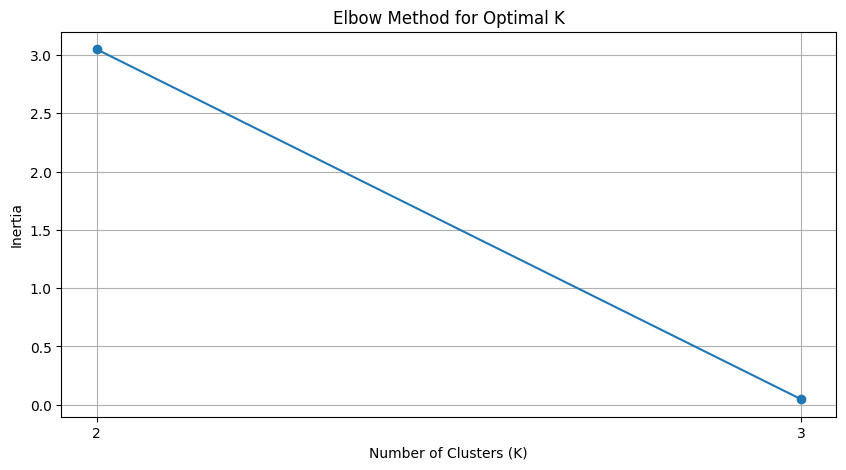

In [ ]:
# Plot the Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.xticks(K_range)
plt.grid(True)
plt.show()

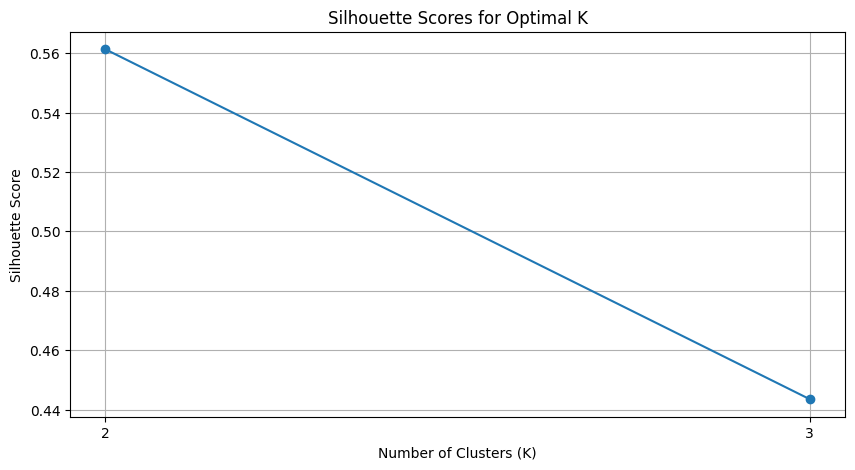

In [ ]:
# Plot Silhouette Scores (if calculated)
if not all(np.isnan(silhouette_scores)):
  plt.figure(figsize=(10, 5))
  plt.plot(K_range, silhouette_scores, marker='o')
  plt.xlabel('Number of Clusters (K)')
  plt.ylabel('Silhouette Score')
  plt.title('Silhouette Scores for Optimal K')
  plt.xticks(K_range)
  plt.grid(True)
  plt.show()

In [ ]:
# 7. Fit KMeans with the chosen number of clusters
# Based on the silhouette scores, optimal K = 2, since 0.56 > 0.44 (Higher silhouette score → better-defined clusters)
optimal_k = 2

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(df_segmentation_scaled)

# Add cluster labels back to the original pivoted DataFrame
df_pivot['Cluster'] = clusters

# Map cluster labels back to the original dataframe based on category
df_market['Cluster'] = df_market[category_col].map(df_pivot['Cluster'])

print(f"\nClustering performed with K = {optimal_k}")
print("\nCategories with their assigned cluster:")
print(df_pivot['Cluster'])


Clustering performed with K = 2

Categories with their assigned cluster:
category
E-2 Wheelers    0
E-3 Wheelers    0
E-4 Wheelers    1
E-Buses         1
Name: Cluster, dtype: int32


In [ ]:
# 8. Profile the segments (clusters of EV categories)
print("\n--- Segment Profiling ---")
# Group by cluster and calculate the mean of the segmentation features
#segment_profiles = df_pivot.groupby('Cluster')[segmentation_features].mean()

segment_profiles_original_scale = df_pivot.groupby('Cluster')[segmentation_features].mean()

print("\nSegment Profiles (Mean of features per cluster - Original Scale):")
print(segment_profiles_original_scale)


--- Segment Profiling ---

Segment Profiles (Mean of features per cluster - Original Scale):
financial_year  Total_Sales  Average_Sales  Growth_Rate
Cluster                                                
0                 1047172.5  299192.142857   184.953153
1                   42054.0   12015.428571    37.113859


In [ ]:
# Category distribution within each cluster
print("\nCategories per Segment:")
for cluster_id in df_pivot['Cluster'].unique():
    categories_in_cluster = df_pivot[df_pivot['Cluster'] == cluster_id].index.tolist()
    print(f"Segment {cluster_id}: {categories_in_cluster}")


Categories per Segment:
Segment 0: ['E-2 Wheelers', 'E-3 Wheelers']
Segment 1: ['E-4 Wheelers', 'E-Buses']


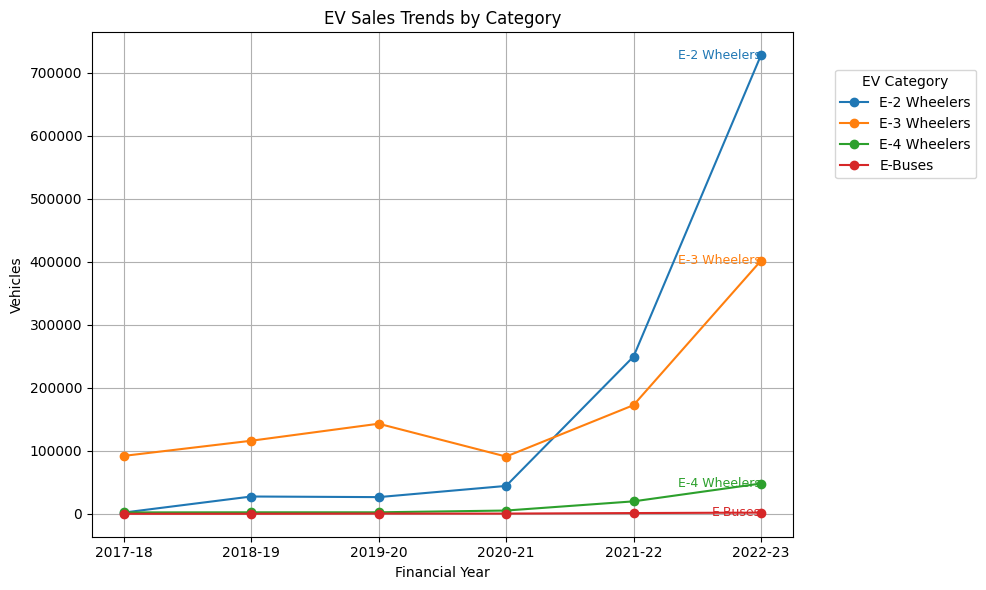

In [ ]:
plt.figure(figsize=(10, 6))

# List of years (exclude metadata columns)
years = [col for col in df_pivot.columns if col not in ['Total_Sales', 'Average_Sales', 'Growth_Rate', 'Cluster']]

# Plot lines and annotate last points
for category in df_pivot.index:
    sales = df_pivot.loc[category, years]
    line = plt.plot(years, sales, marker='o', label=category)

    # Annotate last point
    last_year = years[-1]
    last_value = sales[last_year]
    plt.text(last_year, last_value, category, fontsize=9, va='center', ha='right', color=line[0].get_color())

plt.xlabel("Financial Year")
plt.ylabel("Vehicles")
plt.title("EV Sales Trends by Category")
plt.legend(title='EV Category', bbox_to_anchor=(1.05, 0.94), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()


In [ ]:
# @title
# Visualize sales trends per segment
#plt.figure(figsize=(10,5 ))
#plt.xlabel('Financial Year')
#plt.ylabel('Number of Vehicles Sold')
#plt.title('Sales Trends per EV Category Segment')
#plt.legend(title='EV Category', bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.grid(True)
#plt.tight_layout()
#for cluster_id in sorted(df_pivot['Cluster'].unique()):
#    cluster_categories = df_pivot[df_pivot['Cluster'] == cluster_id].index
    # Years list
#    years_for_plotting = sorted(df_pivot.columns.drop(segmentation_features + ['Cluster'], errors='ignore'))
#    sales_trends = df_pivot.loc[cluster_categories, years_for_plotting]
#        # Plot sales trends for each category in the cluster
#    for category in sales_trends.index:
#        plt.plot(years_for_plotting, sales_trends.loc[category], marker='o', linestyle='-', label=f'Segment {cluster_id} - {category}')
#plt.show()


In [ ]:
# Analysis of segment profiles to understand the characteristics of each group of EV categories.

for cluster_id in segment_profiles_original_scale.index:

    profile = segment_profiles_original_scale.loc[cluster_id]
    categories = df_pivot[df_pivot['Cluster'] == cluster_id].index.tolist()

    print(f"\nSegment {cluster_id} Profile:")
    print(f"  Categories: {categories}")
    print(f"  Average Total Sales: {profile['Total_Sales']:.2f}")
    print(f"  Average Annual Sales: {profile['Average_Sales']:.2f}")
    print(f"  Average Growth Rate: {profile['Growth_Rate']:.2f}")

    if profile['Total_Sales'] > segment_profiles_original_scale['Total_Sales'].mean() and profile['Growth_Rate'] > segment_profiles_original_scale['Growth_Rate'].mean():
      print("  This segment represents high-growth, high-volume EV categories. These could be attractive but potentially competitive markets.")
    elif profile['Total_Sales'] > segment_profiles_original_scale['Total_Sales'].mean():
      print("  This segment represents high-volume, but perhaps slower-growth EV categories. These could be stable markets.")
    elif profile['Growth_Rate'] > segment_profiles_original_scale['Growth_Rate'].mean():
      print("  This segment represents lower-volume but high-growth EV categories. These could be emerging markets with potential.")
    else:
      print("  This segment represents lower-volume, lower-growth EV categories. These might be niche or less promising markets currently.")


Segment 0 Profile:
  Categories: ['E-2 Wheelers', 'E-3 Wheelers']
  Average Total Sales: 1047172.50
  Average Annual Sales: 299192.14
  Average Growth Rate: 184.95
  This segment represents high-growth, high-volume EV categories. These could be attractive but potentially competitive markets.

Segment 1 Profile:
  Categories: ['E-4 Wheelers', 'E-Buses']
  Average Total Sales: 42054.00
  Average Annual Sales: 12015.43
  Average Growth Rate: 37.11
  This segment represents lower-volume, lower-growth EV categories. These might be niche or less promising markets currently.


##### Consider targeting segments with high growth potential, even if current volume is low, as they represent future opportunities.
#####High-volume segments might require significant investment to compete, but offer larger immediate market size.
#####Analyze the specific categories within the most promising segments to understand the competition and specific market needs.
#####Further research into consumer behavior and preferences within the target segments would be crucial for product development.


#####The startup should align its capabilities and resources with the requirements of the chosen segment(s).